R2 Score: 0.6378
Mean Absolute Error: 29.64
Root Mean Squared Error: 88.21
Cross-Validated R2 Score (5-Fold): 0.6351


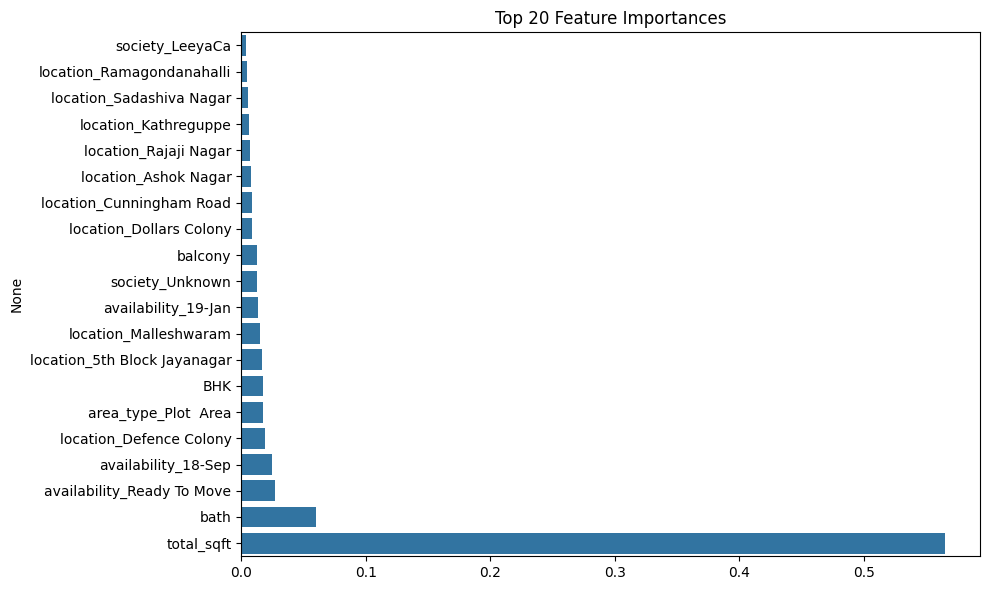

In [7]:
# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 2. Load dataset
df = pd.read_csv("Bengaluru_House_Data.csv")

# 3. Initial Cleaning
df.dropna(subset=["location", "total_sqft", "bath", "balcony", "price"], inplace=True)
df["society"] = df["society"].fillna("Unknown")
df["availability"] = df["availability"].fillna("Ready To Move")
df["balcony"] = df["balcony"].fillna(df["balcony"].median())

# 4. Extract BHK from 'size'
df["BHK"] = df["size"].str.extract(r"(\d+)").astype(float)
df.drop("size", axis=1, inplace=True)

# 5. Handle 'total_sqft' (convert ranges to average)
def convert_sqft(x):
    try:
        if "-" in x:
            tokens = x.split("-")
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return np.nan

df["total_sqft"] = df["total_sqft"].apply(convert_sqft)
df.dropna(subset=["total_sqft"], inplace=True)

# 6. Feature Engineering (one-hot encoding)
df = pd.get_dummies(df, columns=["location", "area_type", "availability", "society"], drop_first=True)

# 7. Define X and y
X = df.drop("price", axis=1)
y = df["price"]

# 8. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Train Model
model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# 10. Evaluate Model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")

# 11. Cross-validation
cv_score = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
print(f"Cross-Validated R2 Score (5-Fold): {cv_score:.4f}")

# 12. Feature Importance Plot (Top 20)
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# 13. Save the Model
with open("bengaluru_price_model_enhanced.pkl", "wb") as f:
    pickle.dump(model, f)


Price Per Sqft - Basic Stats:
count    1.266800e+04
mean     6.876277e+03
std      2.263354e+04
min      2.678298e+02
25%      4.242721e+03
50%      5.376344e+03
75%      7.142857e+03
max      2.300000e+06
Name: price_per_sqft, dtype: float64


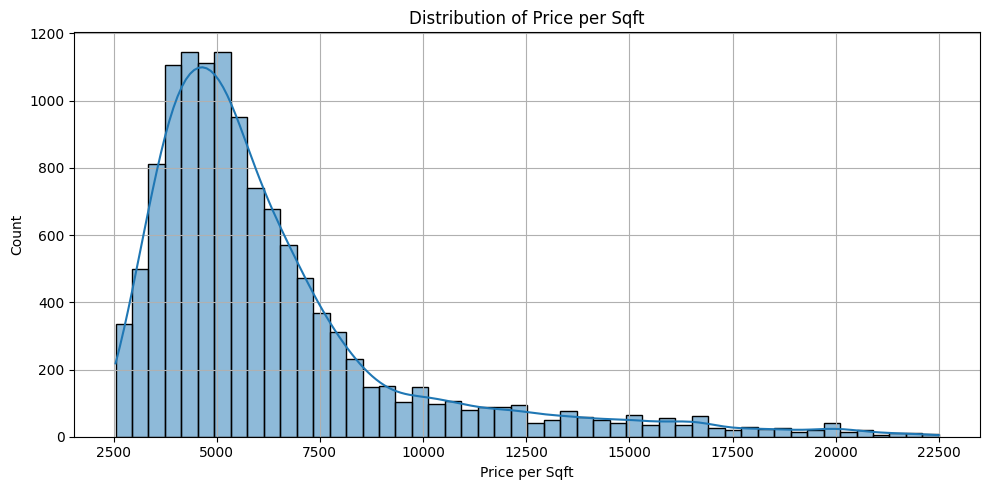

In [8]:
# 1. Calculate price per square foot
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

# 2. Check basic statistics
print("Price Per Sqft - Basic Stats:")
print(df['price_per_sqft'].describe())

# 3. Handle outliers (optional but recommended)
# Remove data points where price per sqft is too extreme (e.g., below 1st or above 99th percentile)
low, high = df['price_per_sqft'].quantile([0.01, 0.99])
df = df[(df['price_per_sqft'] >= low) & (df['price_per_sqft'] <= high)]

# 4. Visualize price per sqft distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True)
plt.title("Distribution of Price per Sqft")
plt.xlabel("Price per Sqft")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
